In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import os
import seaborn as sns
from misc.utils import load_df
from misc.iterators import data_iterators
from misc.MLP import MLP
from pytorch_lightning import utilities
import scipy.integrate as integrate

utilities.seed.seed_everything(seed=0, workers=True)

Global seed set to 0


0

In [2]:
def compare_k_preds(P, T, t, datapath, dataset, model, a, b, N=50, which='both'):
    # Data
    df = load_df(datapath, dataset, which)

    p_values = np.sort(df['P'].unique())
    T_values = np.sort(df['T'].unique())
    t_values = np.sort(df['t'].unique())

    p_idx = np.argmin(np.abs(P - p_values))
    T_idx = np.argmin(np.abs(T - T_values))
    t_idx = np.argmin(np.abs(t - t_values))

    subset = df[(df['P'] == p_values[p_idx]) &
                (df['T'] == T_values[T_idx]) &
                (df['t'] == t_values[t_idx])]

    subset = subset.drop(['M'], axis=1).sort_values('K')
    print(subset['K'].min(), subset['K'].max())
    plt.plot(subset['K'], subset['gamma'], label='data')

    # Model
    K = torch.linspace(a, b, N) * P
    X = torch.zeros(N, 4)
    X[:, 0] = P
    X[:, 1] = K
    X[:, 2] = T
    X[:, 3] = t
    pred = model(X).detach().squeeze()

    plt.plot(K, pred, label='prediction')
    plt.legend()
    plt.show()

    pass


def k_integral(P, T, t, datapath, dataset, model, a, b, N=50, which='both'):
    # Data
    df = load_df(datapath, dataset, which)

    p_values = np.sort(df['P'].unique())
    T_values = np.sort(df['T'].unique())
    t_values = np.sort(df['t'].unique())

    p_idx = np.argmin(np.abs(P - p_values))
    T_idx = np.argmin(np.abs(T - T_values))
    t_idx = np.argmin(np.abs(t - t_values))

    subset = df[(df['P'] == p_values[p_idx]) &
                (df['T'] == T_values[T_idx]) &
                (df['t'] == t_values[t_idx])]

    subset = subset.drop(['M'], axis=1).sort_values('K')

    x, y = subset['K'], subset['gamma']

    # romb_integral = integrate.romb(y, np.diff(x).mean())
    simp_integral = integrate.simpson(y, x=x)
    # Model
    def func(k):
        k = torch.tensor(k)
        X = torch.zeros(len(k), 4)
        X[:, 0] = P
        X[:, 1] = k
        X[:, 2] = T
        X[:, 3] = t
        return np.array(model(X).detach().squeeze())

    model_integral = integrate.quadrature(func, a*P, b*P)

    print(f"""
    Simpson_integral:{simp_integral}    
    Model Integral with Gaussian Quadrature: {model_integral}
    """)


    return

0.949 93.963


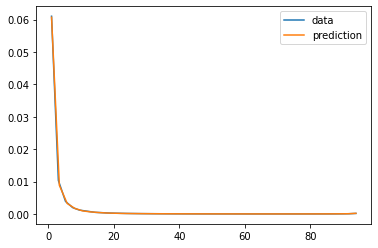


    Simpson_integral:0.09319733473934376    
    Model Integral with Gaussian Quadrature: (0.09454401187168623, 0.00014504800329526168)
    


/home/rodrigo/Desktop/McGill/Research/Rates/rate_modelling/.venv/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:277: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.450480e-04
  warnings.warn(


In [3]:
h_dim = 64
n_layers = 8
method = '0'
batch_size = 64
pc_err = "2.93e-02"

datafile = 'method_0.csv'
datapath = '../datasets'
which = 'both'


results_dir = "Results"
(_, _, test), consts_dict = data_iterators(
    datafile=datafile,
    datapath=datapath,
    batch_size=batch_size,
    which_spacing=which
    )

model_file = f'M_{method}_n_layers_{n_layers}_hid_dim_{h_dim}_val_pc_err={pc_err}.ckpt'
model_path = os.path.join(
    results_dir, "Rate_modelling", "saved_models", f'Method_{method}', model_file
    )
model = MLP.load_from_checkpoint(
    checkpoint_path=model_path,
    hidden_dim=h_dim,
    n_layers=n_layers,
    consts_dict=consts_dict
    )

P = 94.912
T = 0.26
t = 1.05

a = 0.01
b = 0.99
N = 40
compare_k_preds(P, T, t, datapath, datafile, model, a, b, N=N, which=which)
k_integral(P, T, t, datapath, datafile, model, a, b, N=N, which=which)